In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
from decode_fish.funcs.routines import *

import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training

Load base config

In [174]:
cfg = OmegaConf.load('config/train.yaml')

Make dataset specific changes

In [175]:
cfg.output.project = 'rab11_smFISH'

cfg.run_name ='rab11_smFISH_1_5'
cfg.data_path.image_path = base_path + '/datasets/CodFish/smFISH_data_Titlow/rab11_smFISH_1.tif'
cfg.data_path.psf_path = None
cfg.ground_truth = None

cfg.bg_estimation.smoothing_filter_size = 2

cfg.foci.n_foci_avg = 0

cfg.evaluation.txt_path = None
cfg.evaluation.crop_sl = 's_[:,:,200:300,100:200]'
cfg.evaluation.px_size_zyx =  [100,100,100]

cfg.microscope.int_conc = 6.
cfg.microscope.int_rate = 1.
cfg.microscope.int_loc = 1.
cfg.microscope.scale = 1000

cfg.PSF.gauss_radii = [1.2,0.85,0.85]

cfg.prob_generator.low= 0.0001
cfg.prob_generator.high= 0.001

cfg.noise.theta = 100.
cfg.noise.baseline = 0.

cfg.training.num_iters = 20000
cfg.training.start_micro = 3000
cfg.training.start_psf = 3000

Store the config as an experiment

In [176]:
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [116]:
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (43, 48, 48)
1 volumes


Plot projections of the volume

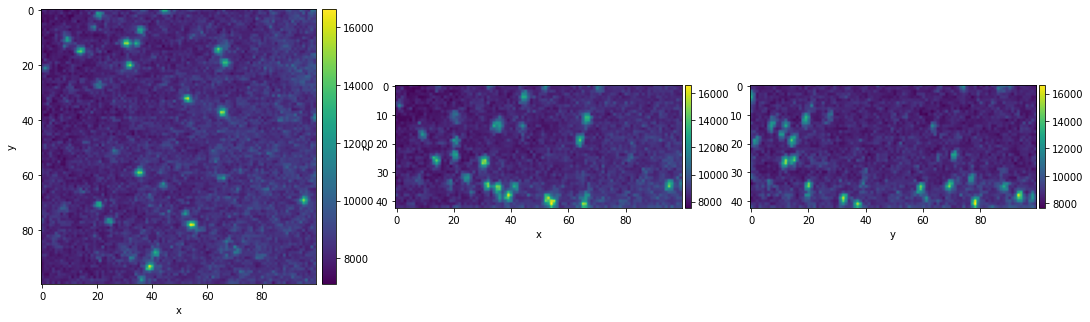

In [117]:
crop_sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(img_3d[cfg.evaluation.img_ind][crop_sl[1:]], 'max')

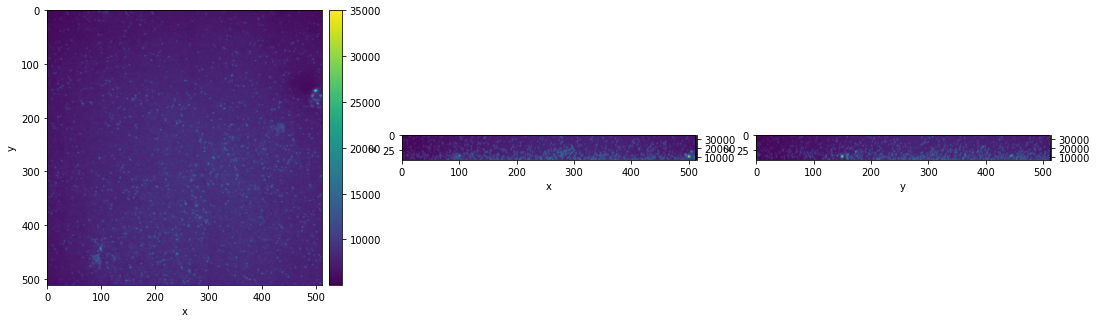

In [118]:
_ = plot_3d_projections(img_3d[cfg.evaluation.img_ind], 'max')

Plot a sample from our dataloader showing a slice from the input volume and from a simulated training volume

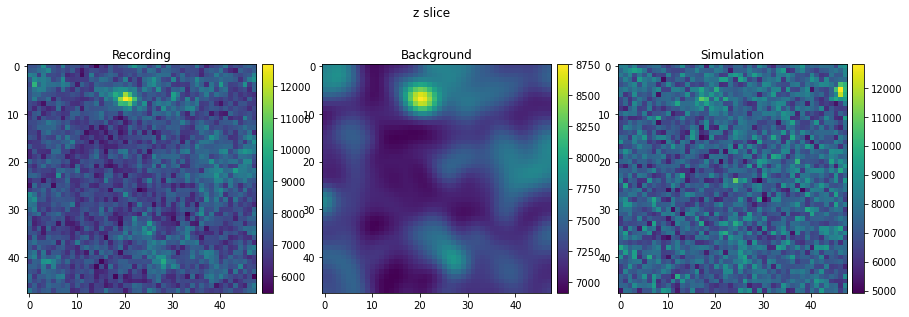

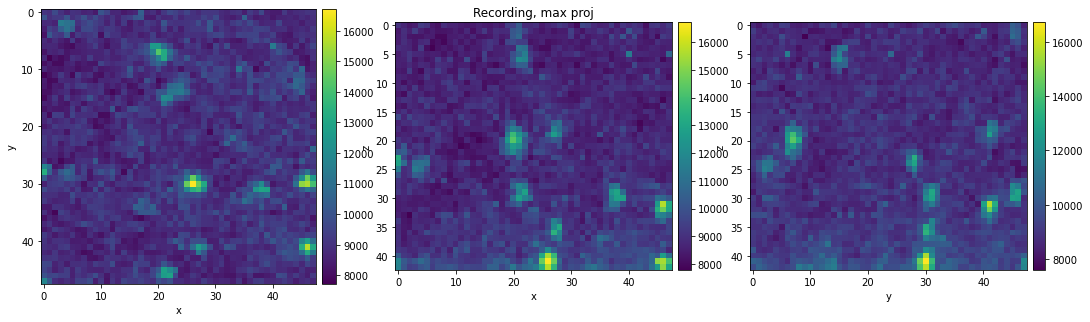

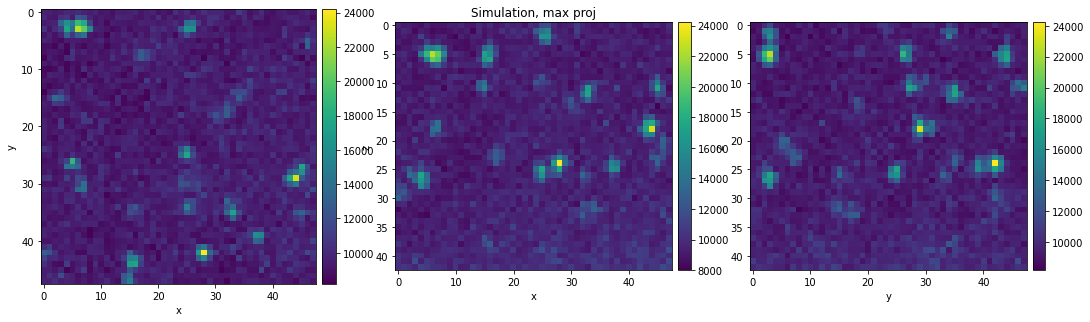

In [123]:
get_simulation_statistics(decode_dl, micro, int_threshold=10000)

Command to train a model on the gpu cluster

In [124]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=rab11_smFISH_1_4'

# Evaluation

In [213]:
cfg = OmegaConf.load(f'config/experiment/rab11_smFISH_1_5.yaml')
# cfg.run_name = 'rab11_nb'
cfg.data_path.image_path = base_path + '/datasets/CodFish/smFISH_data_Titlow/rab11_smFISH_4.tif'
cfg.PSF.psf_extent_zyx = [21,21,21]

In [214]:
model, post_proc, psf, micro, img_3d, decode_dl = load_all(cfg, False)
psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(psf.psf_volume[0])

Crop size larger than volume in at least one dimension. Crop size changed to (36, 48, 48)
1 volumes


In [215]:
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (36, 48, 48)
1 volumes


Plot projections of the PSF before and after optimizing it during training

(tensor(9.9999, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0001, device='cuda:0', grad_fn=<DivBackward0>))
Sum:  25.073027 13.654946
CSum:  26.67619 13.654946


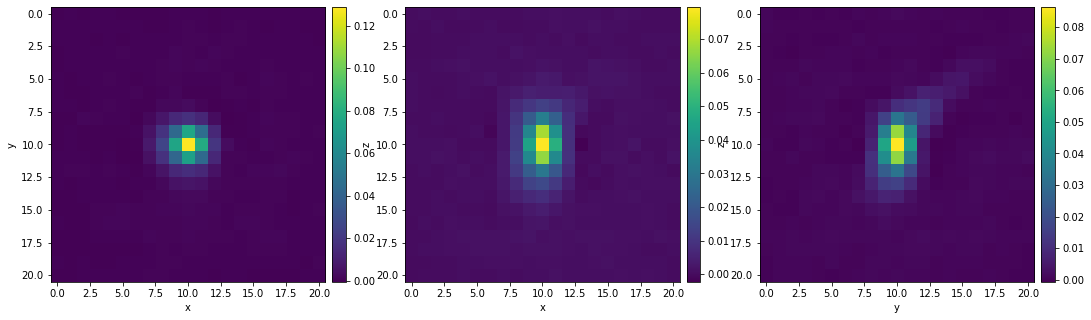

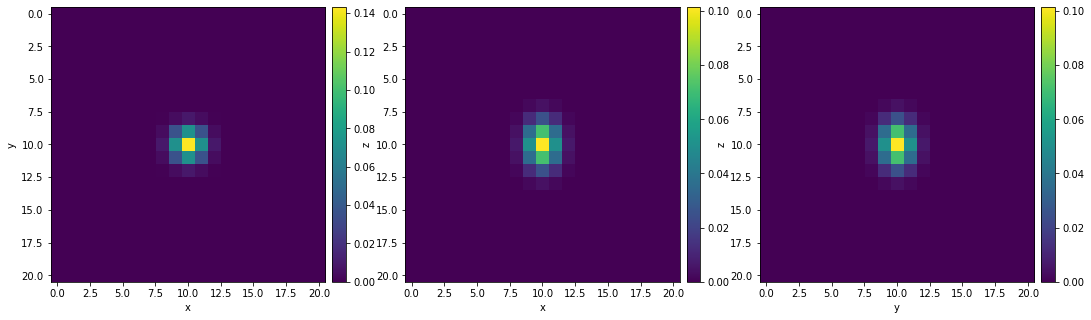

In [216]:
print(psf.get_com())
plot_3d_projections(psf_vol)
plot_3d_projections(psf_init)
print('Sum: ',  psf_vol.sum(), psf_init.sum())
print('CSum: ', np.clip(psf_vol,0,10).sum(), psf_init.sum())

Sample random sub volumes and overlay them with predictions, also show the reconstructions from applying the microscope and psf model to those predictions

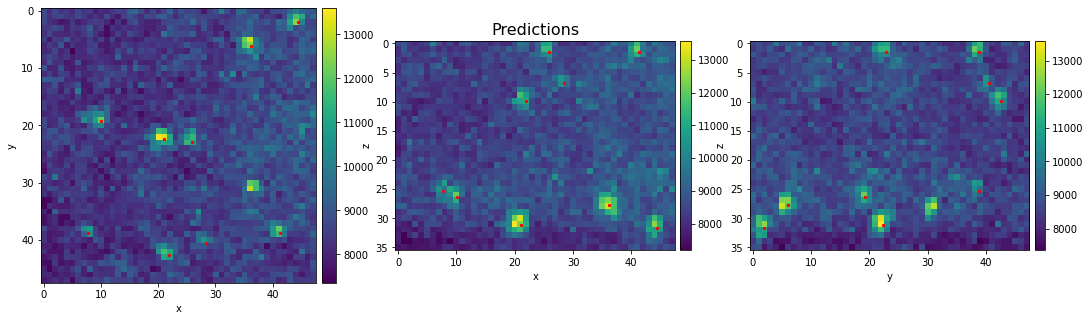

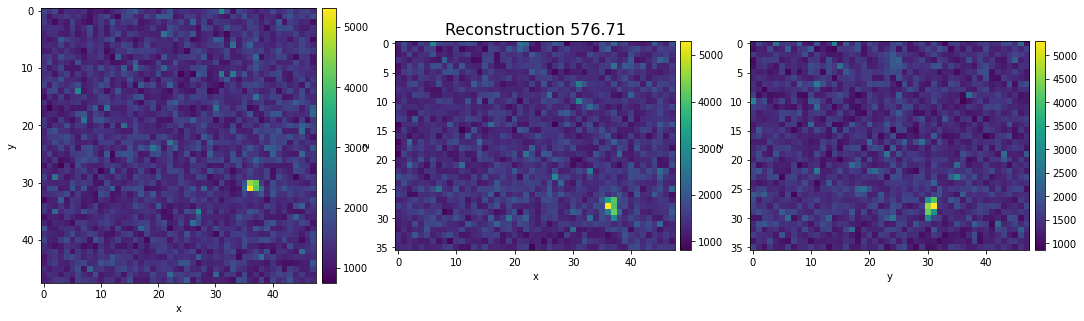

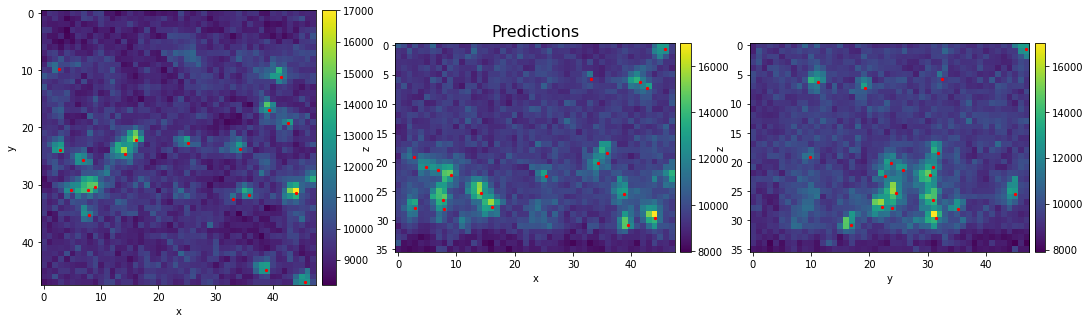

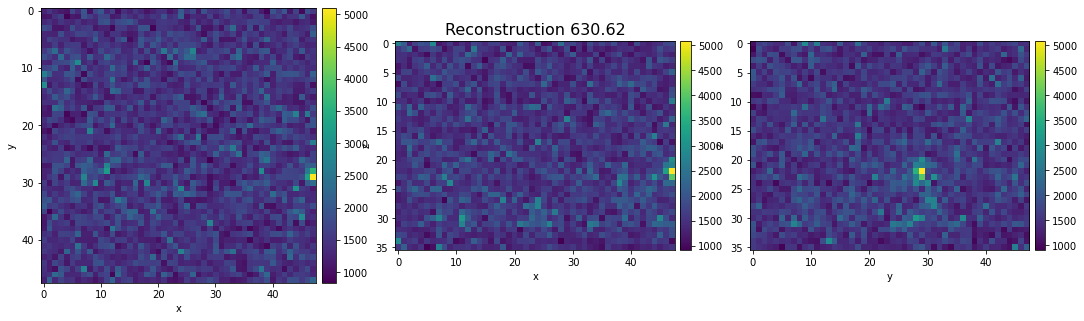

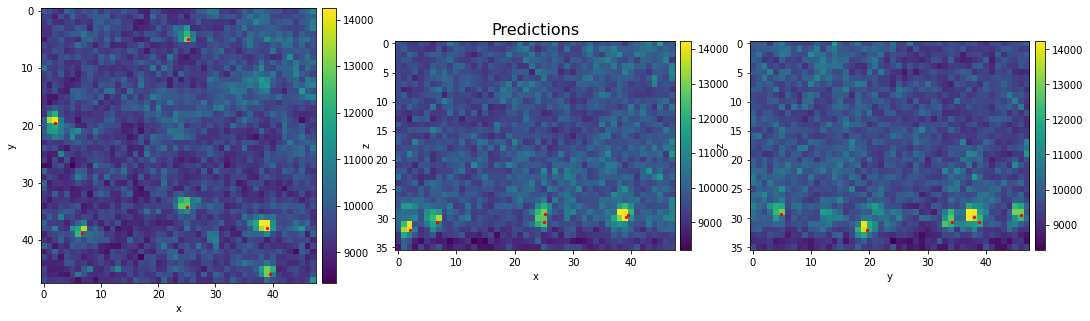

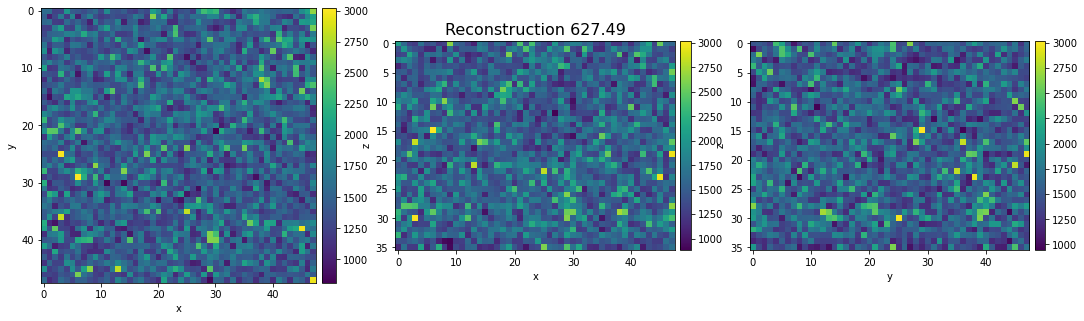

In [225]:
eval_random_crop(decode_dl, model, post_proc, micro, projection='max', samples=3)

In [186]:
dist_samp = cpu(torch.distributions.Gamma(micro.int_conc.item(), micro.int_rate.item()).sample([10000]))+micro.int_loc.item()

(array([6.050e+02, 2.767e+03, 3.295e+03, 1.974e+03, 8.930e+02, 3.210e+02,
        1.080e+02, 2.500e+01, 1.000e+01, 2.000e+00]),
 array([ 3.163793 ,  4.1718407,  5.1798887,  6.1879363,  7.195984 ,
         8.204032 ,  9.212079 , 10.220127 , 11.228175 , 12.236222 ,
        13.24427  ], dtype=float32),
 <BarContainer object of 10 artists>)

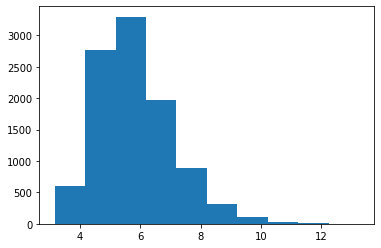

In [187]:
plt.hist(dist_samp)

In [188]:
pp_int = PointProcessUniform(torch.ones([50,100,100]),micro.int_conc, micro.int_rate, micro.int_loc).sample()[-2].numpy()

In [189]:
xsim, gt = sim_data(decode_dl, 10, micro)

In [190]:
model_out = model(xsim)
torch.save(model_out, 'data/model_output_t.pt')

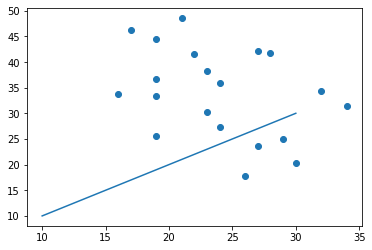

In [191]:
plt.scatter(get_n_locs(gt),cpu(prob_sum))
plt.plot([10,30],[10,30])

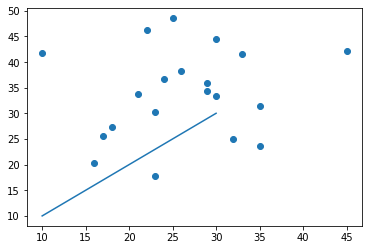

In [192]:
plt.scatter(get_n_locs(pred_df),cpu(prob_sum))
plt.plot([10,30],[10,30])

In [193]:
def get_n_locs(df):
    counts = []
    vcounts = df['frame_idx'].value_counts()
    for i in range(df['frame_idx'].max()+1):
        if i in vcounts.index:
            counts.append(vcounts[i])
    return counts

In [220]:
post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
# post_proc = ISIPostProcess(m1_threshold=0.03, samp_threshold=0.5, px_size_zyx=[100,100,100], diag=True)

In [221]:
perf, pred_df, matches = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

Recall: 0.925
Precision: 0.998
Jaccard: 92.292
RMSE_vol: 24.728
Eff_3d: 85.430
FN: 36.0 FP: 1.0
Shift: 1.13,0.71,12.47


(array([ 42., 155., 127.,  61.,  19.,  10.,   4.,   2.,   2.,   1.]),
 array([0.2776843 , 0.33187127, 0.3860582 , 0.44024518, 0.49443215,
        0.5486191 , 0.6028061 , 0.65699303, 0.71118   , 0.765367  ,
        0.8195539 ], dtype=float32),
 <BarContainer object of 10 artists>)

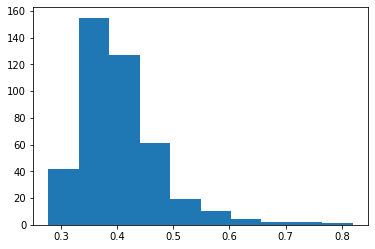

In [197]:
plt.hist(pred_df['int_sig'])

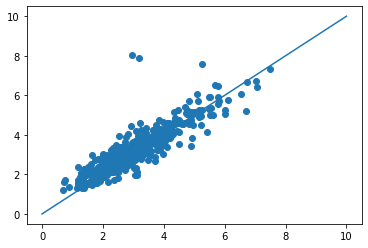

In [198]:
plt.scatter(matches['int_tar'], matches['int_pred'])
plt.plot([0,10],[0,10])

In [171]:
!kill 8817

/bin/bash: line 0: kill: (8817) - No such process


In [172]:
gt['int'].mean()

6.1758957

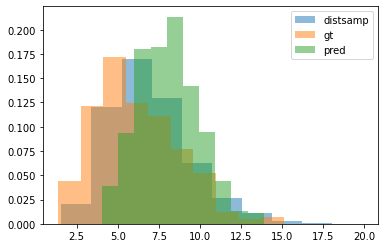

In [173]:
plt.hist(dist_samp, density=True, alpha=0.5,label='distsamp')
plt.hist(gt['int'], density=True, alpha=0.5,label='gt')
plt.hist(pred_df['int'], density=True, alpha=0.5,label='pred')
plt.legend()

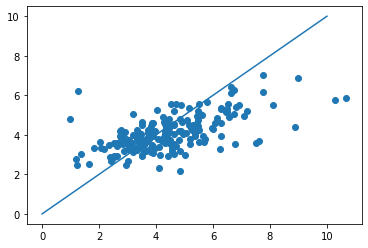

In [245]:
plt.scatter(matches['int_tar'], matches['int_pred'])
plt.plot([0,10],[0,10])

Volume with Foci? Max projection of real volume, reconstruction, difference

In [149]:
pred_df, gt_rec, res_dict = get_prediction(model,post_proc,img_3d[:,250:350,300:400], micro, return_rec=True, cuda=True, min_int=0.3)
_ = gt_plot(img_3d[:,250:350,300:400][None], pred_df, gt_df=None, px_size=[100,100,100], gt_rec=gt_rec[0])
# torch.save(res_dict, 'data/model_output_r.pt')

TypeError: list indices must be integers or slices, not tuple

In [18]:
with torch.no_grad():
    model.cpu()
    res = model(img_3d[None,None])#.to('cuda'))
    pred_df = post_proc(res)
    free_mem()

Inferred intensities

8707


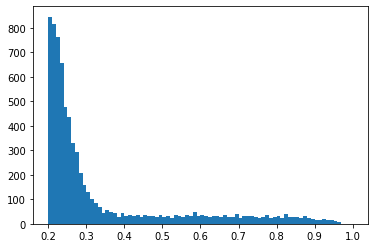

In [20]:
_ = plt.hist(pred_df['int'], bins=np.linspace(0.2,1,81))
print(len(pred_df))

In [ ]:
def scatter3d_df(df, shape, px_size=[100,100,100], color='red', size=1):
    ipv.scatter(df['x']/px_size[0] - 1/2*shape[2], 
                df['y']/px_size[1] - 1/2*shape[1], 
                df['z']/px_size[2] - 1/2*shape[0], size=size, marker='sphere', color=color)

3D rendering

In [ ]:
# vol = img_3d.numpy()

# extent = [[-s/2,s/2] for s in vol.shape]
# extent = [extent[i] for i in [2,1,0]]

# ipv.figure()
# ipv.pylab.volshow(vol, level=[.2,0.25,.1], opacity=[0.04,0.2,0.01], extent=extent)
# scatter3d_df(pred_df, vol.shape, [100.,100.,300.], 'black', size=0.5)
# ipv.xyzlim(max(vol.shape)/2)
# ipv.view(90, 40)
# ipv.show()